In [1]:
using Pkg
Pkg.activate("..")

  Activating project at `~/repos/ProactiveHRI.jl`


In [ ]:
Pkg.instantiate()

In [2]:
include("dynamics.jl")
include("planner.jl")
include("planner_utils.jl")
include("utils.jl")
include("plotting.jl")
include("mpc.jl")
include("sim.jl")

Sim (generic function with 1 method)

### Interaction planner

In [108]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([1.0; 1.0]) 
Qt = diagm([10.; 10.; 0.])
markup = 1.05
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 150.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [109]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [10.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi]
human_goal_state = [0.; 0.; pi]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)
# 
# ip = InteractionPlanner(human_hps, 
#                         robot_hps,
#                         human_initial_state,
#                         robot_initial_state,
#                         human_goal_state,
#                         robot_goal_state,
#                         solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [110]:
incon_problem, xs, us = @time solve(ip.ego_planner.incon, iterations=10, verbose=false, keep_history=false)
incon_problem, xs, us = @time solve(ip.other_planner.incon, iterations=10, verbose=false, keep_history=false);



  0.103169 seconds (418.59 k allocations: 37.465 MiB, 4.12% compilation time)


  0.094164 seconds (387.19 k allocations: 34.361 MiB)


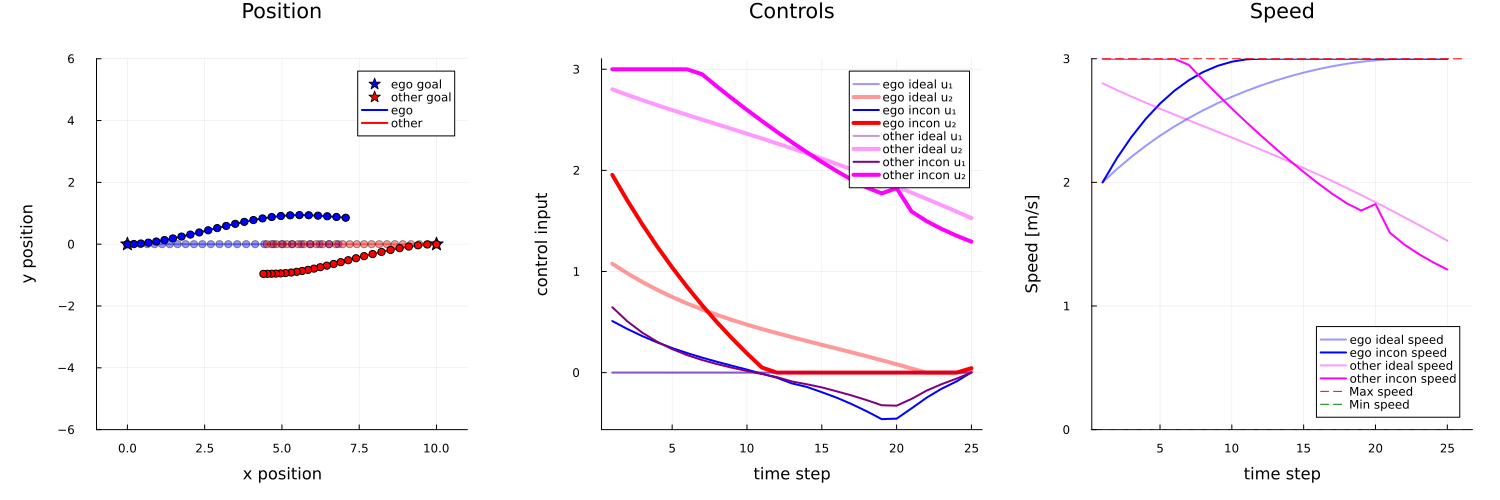

In [111]:
plot_solve_solution(ip, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Iterated Best Response

In [ ]:
@time ibr(ip, 3, "ego")

In [ ]:
plot_solve_solution(ip, pos_xlims=[-1, 11], pos_ylims=[-6, 6])

# Animation

In [ ]:
animation(ip, pos_xlims=[-1, 11], pos_ylims=[-4, 4])

In [ ]:
avoidance_animation(ip, pos_xlims=[0, 10], pos_ylims=[-5, 5])

# MPC Controller Simulation
*At the moment it is a known issue that the sim breaks if the dynamics classes used are different between the different InteractionPlanner models, will be fixed

In [ ]:
include("sim.jl")
include("mpc.jl")
using AngleBetweenVectors

In [ ]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [2 * pi, 2.])
# human = Unicycle(dt, velocity_max, [0.5, 3.])
human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
#SingleIntegratorPolar2D
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
# unicycle
# Q = diagm([0.0; 0.0; 0.])
# R = diagm([1.0; .1]) 
# Qt = diagm([10.; 10.; 0.])
# dynamicalyl extended unicycle
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 1.1
collision_slack = 250.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

In [ ]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [30.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi; 2]
human_goal_state = [-20.; 0.; pi; 2]

solver = "ECOS"

robot_ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)


In [ ]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [3 * pi / 2, 2.])
human = Unicycle(dt, velocity_max, [0.5, 3.])
human = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
#SingleIntegratorPolar2D
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
# unicycle
# Q = diagm([0.0; 0.0; 0.])
# R = diagm([1.0; .1]) 
# Qt = diagm([10.; 10.; 0.])
# dynamicalyl extended unicycle
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])
markup = 1.1
collision_slack = 250.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.1]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)

In [ ]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [30.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi; 2]
human_goal_state = [-20.; 0.; pi; 2]

solver = "ECOS"

human_ip = InteractionPlanner(human_hps, 
                        robot_hps,
                        human_initial_state,
                        robot_initial_state,
                        human_goal_state,
                        robot_goal_state,
                        solver)

In [ ]:
robot_path, robot_controls, human_path, human_controls = Sim(robot_ip, human_ip, 75, leader="ego")

In [ ]:
plt = plot(robot_path[:,1], robot_path[:,2], xlims=[-10, 30], ylims=[-5, 5])
plot!(plt, human_path[:,1], human_path[:,2])

In [ ]:
animation(robot_path, human_path, pos_xlims=[-10, 20], pos_ylims=[-2.5, 2.5])

# Summary Plots
Want summary plots from single iteration of the algorithm to include: path iterations, speed or control input iterations (ego), speed or control input iterations (other), collision violation iterations, inconvenience iterations 

### Setup the planner

In [227]:
dt = 0.1
velocity_max = 3.0
# human = SingleIntegratorPolar2D(dt, velocity_max, [pi, 2.])
human = Unicycle(dt, velocity_max, [1., 3.])

time_horizon = 25
# Q = zeros(Float64, human.state_dim, human.state_dim)
# R = diagm([0.; 0.1]) 
# Qt = diagm([10.; 10.])
Q = diagm([0.0; 0.0; 0.])
R = diagm([1.0; 0.0]) 
Qt = diagm([10.; 10.; 0.])
markup = 1.05
collision_slack = 150.
trust_region_weight = 5.
inconvenience_weights = [1.; 1.; 0.01]
collision_radius = 1.
inconvenience_ratio = 0.2


human_hps = PlannerHyperparameters(dynamics=human,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)



dt = 0.1
velocity_max = 3.0
# robot = Unicycle(dt, velocity_max, [1.0, 2.])
robot = DynamicallyExtendedUnicycle(dt, velocity_max, [1., 3.])

# time_horizon = 45
Q = diagm([0.0; 0.0; 0.; 0.])
R = diagm([1.; 1.]) 
Qt = diagm([10.; 10.; 0.; 0.])

robot_hps = PlannerHyperparameters(dynamics=robot,
                             time_horizon=time_horizon,
                             Q=Q,
                             R=R,
                             Qt=Qt,
                             markup=markup,
                             collision_slack=collision_slack,
                             trust_region_weight=trust_region_weight,
                             inconvenience_weights=inconvenience_weights,
                             collision_radius=collision_radius,
                             inconvenience_ratio=inconvenience_ratio)


PlannerHyperparameters{Float64}
  dynamics: DynamicallyExtendedUnicycle{Float64}
  time_horizon: Int64 25
  Q: Array{Float64}((4, 4)) [0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  R: Array{Float64}((2, 2)) [1.0 0.0; 0.0 1.0]
  Qt: Array{Float64}((4, 4)) [10.0 0.0 0.0 0.0; 0.0 10.0 0.0 0.0; 0.0 0.0 0.0 0.0; 0.0 0.0 0.0 0.0]
  markup: Float64 1.05
  collision_slack: Float64 150.0
  trust_region_weight: Float64 5.0
  inconvenience_weights: Array{Float64}((3,)) [1.0, 1.0, 0.01]
  collision_radius: Float64 1.0
  inconvenience_ratio: Float64 0.2


In [228]:
robot_initial_state = [0.; 0.; 0.; 2.]
robot_goal_state = [10.; 0.; 0.; 2.]
human_initial_state = [10.; 0.; pi]
human_goal_state = [0.; 0.; pi]
solver = "ECOS"

ip = InteractionPlanner(robot_hps, 
                        human_hps,
                        robot_initial_state,
                        human_initial_state,
                        robot_goal_state,
                        human_goal_state,
                        solver)

InteractionPlanner
  ego_planner: AgentPlanner
  other_planner: AgentPlanner


In [229]:
incon_problem, xs, us = @time solve(ip.ego_planner.incon, iterations=10, verbose=false, keep_history=false)
incon_problem, xs, us = @time solve(ip.other_planner.incon, iterations=10, verbose=false, keep_history=false);

  0.113185 seconds (418.62 k allocations: 37.615 MiB)


  0.099556 seconds (386.41 k allocations: 34.193 MiB)


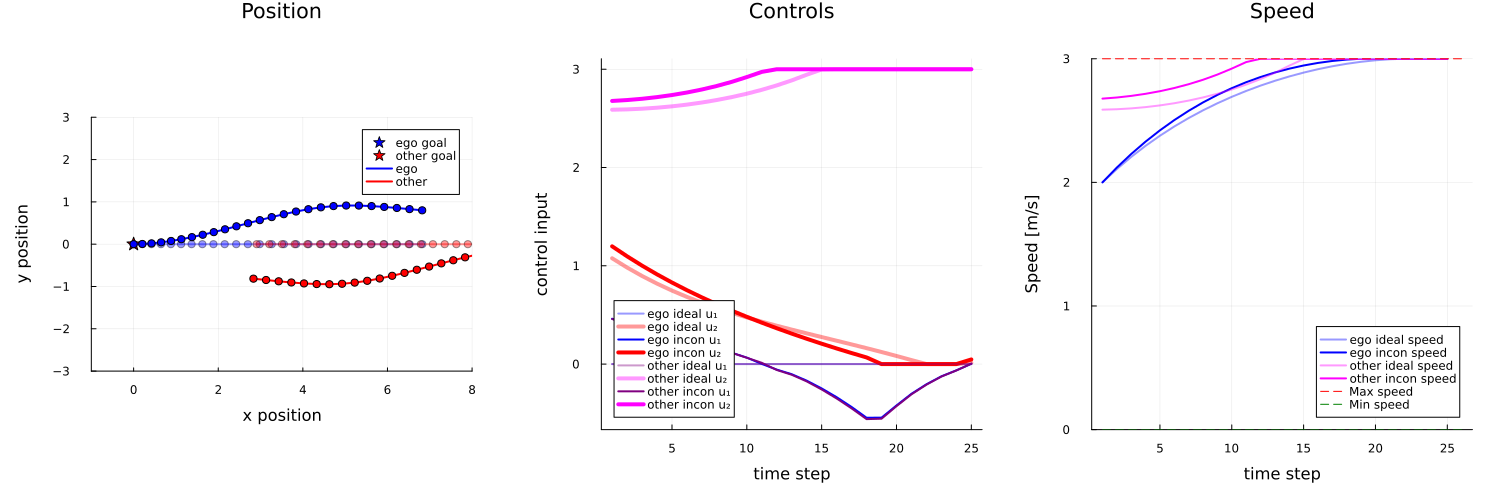

In [230]:
plot_solve_solution(ip)

In [184]:
@with_kw mutable struct SaveData
    previous_ips::Vector{InteractionPlanner}
end

function ibr(ip::InteractionPlanner, iterations::Int64, leader="ego"::String, save_flag=""::String)     # for param sweep saving
    if leader != "ego"                       # determine which agent solves leader
        leader_agent = ip.other_planner
        follower_agent = ip.ego_planner
    else
        leader_agent = ip.ego_planner
        follower_agent = ip.other_planner
    end

    data = SaveData(Vector{InteractionPlanner}(undef, iterations))

    # ideal_path computation for ego and other
    # opt_params.inconvenience_budget for ego and other

    for i in 1:iterations
        
        # linearize collision avoidance constraints
        # linearize dynamics
        # update JuMP model
        # update previous state and controls with latest solution
        leader_agent.incon.opt_params.other_positions = get_position(follower_agent.incon.hps.dynamics, follower_agent.incon.opt_params.previous_states)
        solve(leader_agent.incon, iterations=1)
        follower_agent.incon.opt_params.other_positions = get_position(leader_agent.incon.hps.dynamics, leader_agent.incon.opt_params.previous_states)
        solve(follower_agent.incon, iterations=1)
        data.previous_ips[i] = deepcopy(ip)     # store data at each iteration

    end

    # ip, value.(ip.ego_planner.incon.xs), value.(ip.ego_planner.incon.us), value.(ip.ego_planner.incon.us)[1]
    data
end

ibr (generic function with 3 methods)

In [231]:
saved_data_test = ibr(ip, 3, "ego")

SaveData
  previous_ips: Array{InteractionPlanner}((3,))


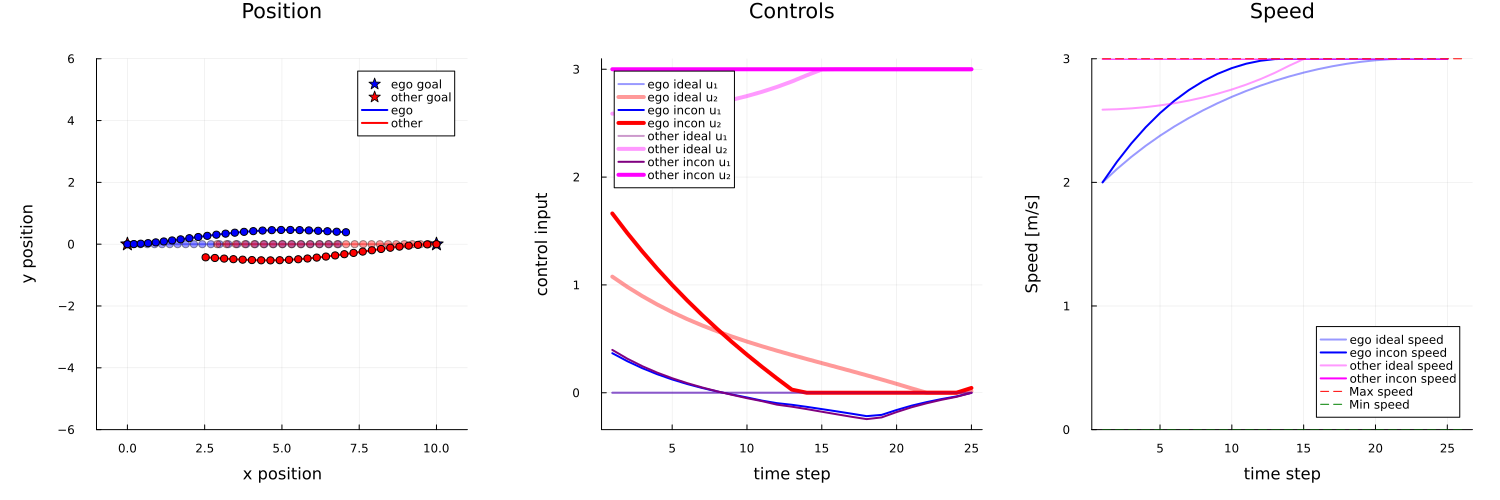

In [246]:
plot_solve_solution(saved_data_test.previous_ips[3], pos_xlims=[-1, 11], pos_ylims=[-6, 6])

In [562]:
# summary plots dependent on iterations

function plot_solve_solution(problem::SaveData; pos_xlims=[-1,11], pos_ylims=[-6, 6], scatter=true::Bool, show_speed=true::Bool, show_control=true::Bool)

    l = @layout [a b c d e] 
    width=2000
    height=400
    alpha_ideal = 0.4
    linewidth = 2
    markersize = 2
    markersize_large = 7
    ego_color = :blue
    other_color = :red

    iterations = length(problem.previous_ips)

    alpha_ratio = 1 / (iterations + 1)
    N = problem.previous_ips[1].ego_planner.ideal.hps.time_horizon

    ego_goal_state = problem.previous_ips[1].ego_planner.ideal.opt_params.goal_state
    other_goal_state = problem.previous_ips[1].other_planner.ideal.opt_params.goal_state

    ego_dynamics = problem.previous_ips[1].ego_planner.ideal.hps.dynamics       # use first ip arbitrarily, any iteration will give the same values for these entries
    other_dynamics = problem.previous_ips[1].other_planner.ideal.hps.dynamics

    # plotting position trajectory

    plot_traj = plot(size=(height, height), xlabel="x position", ylabel="y position", title="Position", margin=10mm, ylims=pos_ylims, xlims=pos_xlims, aspect_ratio=:equal)
    scatter!(ego_goal_state[1:1], ego_goal_state[2:2], marker=:star, markersize=markersize_large, color=ego_color, label="ego goal")
    scatter!(plot_traj, other_goal_state[1:1], other_goal_state[2:2], marker=:star, markersize=markersize_large, color=other_color, label="other goal")

    plot!(plot_traj, value.(problem.previous_ips[1].ego_planner.ideal.model[:x])[:,1], value.(problem.previous_ips[1].ego_planner.ideal.model[:x])[:,2], color=ego_color, linewidth=linewidth, label="", alpha=alpha_ratio)

    plot!(plot_traj, value.(problem.previous_ips[1].other_planner.ideal.model[:x])[:,1], value.(problem.previous_ips[1].other_planner.ideal.model[:x])[:,2], color=other_color, linewidth=linewidth, label="", alpha=alpha_ratio)

    if scatter
        scatter!(plot_traj, value.(problem.previous_ips[1].ego_planner.ideal.model[:x])[:,1], value.(problem.previous_ips[1].ego_planner.ideal.model[:x])[:,2], color=ego_color, linewidth=linewidth, label="", alpha=alpha_ratio)

        scatter!(plot_traj, value.(problem.previous_ips[1].other_planner.ideal.model[:x])[:,1], value.(problem.previous_ips[1].other_planner.ideal.model[:x])[:,2], color=other_color, linewidth=linewidth, label="", alpha=alpha_ratio)
    end

    for i in 1:iterations
        plot!(plot_traj, vector_of_vectors_to_matrix(problem.previous_ips[i].ego_planner.incon.opt_params.previous_states)[:,1], vector_of_vectors_to_matrix(problem.previous_ips[i].ego_planner.incon.opt_params.previous_states)[:,2], color=ego_color, linewidth=linewidth, label="", alpha=(i * alpha_ratio))

        plot!(plot_traj, vector_of_vectors_to_matrix(problem.previous_ips[i].other_planner.incon.opt_params.previous_states)[:,1], vector_of_vectors_to_matrix(problem.previous_ips[i].other_planner.incon.opt_params.previous_states)[:,2], color=other_color, linewidth=linewidth, label="", alpha=(i * alpha_ratio))

        if scatter
            scatter!(plot_traj, vector_of_vectors_to_matrix(problem.previous_ips[i].ego_planner.incon.opt_params.previous_states)[:,1], vector_of_vectors_to_matrix(problem.previous_ips[i].ego_planner.incon.opt_params.previous_states)[:,2], color=ego_color, label="", alpha=(i * alpha_ratio))

            scatter!(plot_traj, vector_of_vectors_to_matrix(problem.previous_ips[i].other_planner.incon.opt_params.previous_states)[:,1], vector_of_vectors_to_matrix(problem.previous_ips[i].other_planner.incon.opt_params.previous_states)[:,2], color=other_color, label="", alpha=(i * alpha_ratio))
        end
    end

    if !scatter
        plot_traj[1][end - 1][:label] = "Ego Path"
        plot_traj[1][end][:label] = "Other Path"
    else
        plot_traj[1][end - 3][:label] = "Ego Path"
        plot_traj[1][end - 2][:label] = "Other Path"
    end
    # plotting speed/control

    # speed parameters
    max_speed = maximum([problem.previous_ips[1].ego_planner.ideal.hps.dynamics.velocity_max, problem.previous_ips[1].other_planner.ideal.hps.dynamics.velocity_max])
    ego_max_speed = problem.previous_ips[1].ego_planner.ideal.hps.dynamics.velocity_max
    other_max_speed = problem.previous_ips[1].other_planner.ideal.hps.dynamics.velocity_max

    # control parameters
    ego_ctrl_dim = problem.previous_ips[1].ego_planner.ideal.hps.dynamics.ctrl_dim
    other_ctrl_dim = problem.previous_ips[1].other_planner.ideal.hps.dynamics.ctrl_dim

    ego_max_ctrl = maximum(problem.previous_ips[1].ego_planner.ideal.hps.dynamics.control_max)
    ego_min_ctrl = minimum(problem.previous_ips[1].ego_planner.ideal.hps.dynamics.control_min)
    other_max_ctrl = maximum(problem.previous_ips[1].other_planner.ideal.hps.dynamics.control_max)
    other_min_ctrl = minimum(problem.previous_ips[1].other_planner.ideal.hps.dynamics.control_min)

    if show_speed & !show_control
        plot_speed_ego = plot(size=(height, height), xlabel="time step", ylabel="Speed [m/s]", title="Ego Speed", margin=10mm, ylim=[0, max_speed], legend=:bottomright)
        plot!(plot_speed_ego, 1:N+1, ego_max_speed * ones(Float64, N+1), linestyle=:dash, linewith=linewidth, color=:black, label="Max speed", linewidth=linewidth)
        plot!(plot_speed_ego, 1:N+1, 0 * ones(Float64, N+1), linestyle=:dash, linewith=linewidth, color=:green, label="Min speed", linewidth=linewidth)

        plot_speed_other = plot(size=(height, height), xlabel="time step", ylabel="Speed [m/s]", title="Other Speed", margin=10mm, ylim=[0, max_speed], legend=:bottomright)
        plot!(plot_speed_other, 1:N+1, other_max_speed * ones(Float64, N+1), linestyle=:dash, linewith=linewidth, color=:black, label="Max speed", linewidth=linewidth)
        plot!(plot_speed_other, 1:N+1, 0 * ones(Float64, N+1), linestyle=:dash, linewith=linewidth, color=:green, label="Min speed", linewidth=linewidth)

        for i in 1:iterations
            ego_speed = get_speed(ego_dynamics, vector_of_vectors_to_matrix(problem.previous_ips[i].ego_planner.incon.opt_params.previous_states), vector_of_vectors_to_matrix(problem.previous_ips[i].ego_planner.incon.opt_params.previous_controls))
            other_speed = get_speed(other_dynamics, vector_of_vectors_to_matrix(problem.previous_ips[i].other_planner.incon.opt_params.previous_states), vector_of_vectors_to_matrix(problem.previous_ips[i].other_planner.incon.opt_params.previous_controls))

            plot!(plot_speed_ego, 1:N, ego_speed[1:N], alpha=(i * alpha_ratio), color=ego_color, label="", linewidth=linewidth)
            plot!(plot_speed_other, 1:N, other_speed[1:N], alpha=(i * alpha_ratio), color=other_color, label="", linewidth=linewidth)
        end

        plot_speed_ego[1][end][:label] = "Ego Speed"
        plot_speed_other[1][end][:label] = "Other Speed"

    elseif show_control & !show_speed
        plot_ctrl_ego = plot(size=(height, height), xlabel="time step", ylabel="input magnitude", title="Ego Control", margin=10mm)
        plot_ctrl_other = plot(size=(height, height), xlabel="time step", ylabel="input magnitude", title="Other Control", margin=10mm)

        plot!(plot_ctrl_ego, 1:N, ego_max_ctrl * ones(Float64, N), linestyle=:dash, linewith=linewidth, color=:green, label="Control Limits")
        plot!(plot_ctrl_ego, 1:N, ego_min_ctrl * ones(Float64, N), linestyle=:dash, linewith=linewidth, color=:green, label="")
        plot!(plot_ctrl_other, 1:N, other_max_ctrl * ones(Float64, N), linestyle=:dash, linewith=linewidth, color=:green, label="Control Limits")
        plot!(plot_ctrl_other, 1:N, other_min_ctrl * ones(Float64, N), linestyle=:dash, linewith=linewidth, color=:green, label="")

        # nested for loops :|
        for i in 1:iterations
            # ego plot
            for j in 1:ego_ctrl_dim
                plot!(plot_ctrl_ego, 1:N, vector_of_vectors_to_matrix(problem.previous_ips[i].ego_planner.incon.opt_params.previous_controls)[:, j], label="", color=RGB(1 - (1 / ego_ctrl_dim) * j, 0., (1 / ego_ctrl_dim) * j), linewidth=linewidth, alpha=(i * alpha_ratio))
            end

            # other plot
            for k in 1:other_ctrl_dim
                plot!(plot_ctrl_other, 1:N, vector_of_vectors_to_matrix(problem.previous_ips[i].other_planner.incon.opt_params.previous_controls)[:, k], label="", color=RGB((1 / other_ctrl_dim) * k, 1 - (1 / other_ctrl_dim) * k, 0.), linewidth=linewidth, alpha=(i * alpha_ratio))
            end
        end

        for l in 1:ego_ctrl_dim
            plot_ctrl_ego[1][end - l][:label] = "u$(ego_ctrl_dim - l + 1)"
        end

        for m in 1:ego_ctrl_dim
            plot_ctrl_other[1][end - m][:label] = "u$(ego_ctrl_dim - m + 1)"
        end
    elseif show_speed & show_control
        plot_speed = plot(size=(height, height), xlabel="time step", ylabel="Speed [m/s]", title="Speed", margin=10mm, ylim=[0, max_speed], legend=:bottomright)
        plot_ctrl = plot(size=(height, height), xlabel="time step", ylabel="input magnitude", title="Control", margin=10mm)

        # speed plotting
        plot!(plot_speed, 1:N+1, maximum([ego_max_speed, other_max_speed]) * ones(Float64, N+1), linestyle=:dash, linewith=linewidth, color=:black, label="Max speed", linewidth=linewidth)
        plot!(plot_speed, 1:N+1, 0 * ones(Float64, N+1), linestyle=:dash, linewith=linewidth, color=:green, label="Min speed", linewidth=linewidth)

        for i in 1:iterations
            ego_speed = get_speed(ego_dynamics, vector_of_vectors_to_matrix(problem.previous_ips[i].ego_planner.incon.opt_params.previous_states), vector_of_vectors_to_matrix(problem.previous_ips[i].ego_planner.incon.opt_params.previous_controls))
            other_speed = get_speed(other_dynamics, vector_of_vectors_to_matrix(problem.previous_ips[i].other_planner.incon.opt_params.previous_states), vector_of_vectors_to_matrix(problem.previous_ips[i].other_planner.incon.opt_params.previous_controls))

            plot!(plot_speed, 1:N, ego_speed[1:N], alpha=(i * alpha_ratio), color=ego_color, label="", linewidth=linewidth)
            plot!(plot_speed, 1:N, other_speed[1:N], alpha=(i * alpha_ratio), color=other_color, label="", linewidth=linewidth)
        end
        plot_speed[1][end - 1][:label] = "Ego Speed"
        plot_speed[1][end][:label] = "Other Speed"

        # ctrl plotting
        plot!(plot_ctrl, 1:N, maximum([ego_max_ctrl, other_max_ctrl]) * ones(Float64, N), linestyle=:dash, linewith=linewidth, color=:green, label="Control Limits")
        plot!(plot_ctrl, 1:N, minimum([ego_min_ctrl, other_min_ctrl]) * ones(Float64, N), linestyle=:dash, linewith=linewidth, color=:green, label="")

        for i in 1:iterations
            # ego plot
            for j in 1:ego_ctrl_dim
                plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(problem.previous_ips[i].ego_planner.incon.opt_params.previous_controls)[:, j], label="", color=RGB(1 - (1 / ego_ctrl_dim) * j, 0., (1 / ego_ctrl_dim) * j), linewidth=linewidth, alpha=(i * alpha_ratio))
            end

            # other plot
            for k in 1:other_ctrl_dim
                plot!(plot_ctrl, 1:N, vector_of_vectors_to_matrix(problem.previous_ips[i].other_planner.incon.opt_params.previous_controls)[:, k], label="", color=RGB((1 / other_ctrl_dim) * k, 1 - (1 / other_ctrl_dim) * k, 0.), linewidth=linewidth, alpha=(i * alpha_ratio))
            end
        end

        # for l in 1:ego_ctrl_dim
        #     plot_ctrl[1][end - (l - 1)][:label] = "Ego u$(ego_ctrl_dim - l + 1)"
        # end

        # for m in 1:ego_ctrl_dim
            # plot_ctrl[1][end - (m + 1)][:label] = "Other u$(other_ctrl_dim - m + 1)"
        # end
        plot_ctrl[1][end - 1][:label] = "Other u$(ego_ctrl_dim - 1 + 1)"
    end

    # plotting slack violation over iterations

    slack_violation = Vector{Float64}(undef, iterations)

    for i in 1:iterations
        slack_violation[i] = value(problem.previous_ips[i].ego_planner.incon.model[:ϵ])
    end

    plot_slack_violation = plot(size=(height, height), xlabel="Iteration", ylabel="ϵ (slack value)", title="Slack (collision) Violation", margin=10mm)

    plot!(plot_slack_violation, 1:iterations, slack_violation, color=:black, label="Slack")

    # plotting inconvenience value over iterations

    incon_budget = problem.previous_ips[1].ego_planner.incon.hps.inconvenience_ratio
    inconvenience_ego = Vector{Float64}(undef, iterations)
    inconvenience_other = Vector{Float64}(undef, iterations)

    ideal_incon_ego = compute_convenience_value(ego_dynamics, matrix_to_vector_of_vectors(value.(problem.previous_ips[1].ego_planner.ideal.model[:x])), matrix_to_vector_of_vectors(value.(problem.previous_ips[1].ego_planner.ideal.model[:u])), ego_goal_state, problem.previous_ips[1].ego_planner.incon.hps.inconvenience_weights)

    ideal_incon_other = compute_convenience_value(other_dynamics, matrix_to_vector_of_vectors(value.(problem.previous_ips[1].other_planner.ideal.model[:x])), matrix_to_vector_of_vectors(value.(problem.previous_ips[1].other_planner.ideal.model[:u])), other_goal_state, problem.previous_ips[1].other_planner.incon.hps.inconvenience_weights)

    for i in 1:iterations
        inconvenience_ego[i] = compute_convenience_value(ego_dynamics, problem.previous_ips[i].ego_planner.incon.opt_params.previous_states, problem.previous_ips[i].ego_planner.incon.opt_params.previous_controls, ego_goal_state, problem.previous_ips[1].ego_planner.incon.hps.inconvenience_weights)
        
        inconvenience_other[i] = compute_convenience_value(other_dynamics, problem.previous_ips[i].other_planner.incon.opt_params.previous_states, problem.previous_ips[i].other_planner.incon.opt_params.previous_controls, other_goal_state, problem.previous_ips[1].other_planner.incon.hps.inconvenience_weights)
    end

    inconvenience_ego ./= ideal_incon_ego
    inconvenience_other ./= ideal_incon_other 

    plot_incon = plot(size=(height, height), xlabel="Iteration", ylabel="Inconvenience", title="Agent Inconvenience", margin=10mm)
    plot!(plot_incon, 1:iterations, ones(iterations), linestyle=:dash, linewith=linewidth, color=:green, label="Ideal Incon")
    plot!(plot_incon, 1:iterations, ones(iterations) .+ incon_budget, linestyle=:dash, linewith=linewidth, color=:black, label="Incon Budget")
    plot!(plot_incon, 1:iterations, inconvenience_ego, color=ego_color, linewidth=linewidth, label="Ego Incon")
    plot!(plot_incon, 1:iterations, inconvenience_other, color=other_color, linewidth=linewidth, label="Other Incon")


    if show_speed & !show_control
        plot(plot_traj, plot_speed_ego, plot_speed_other, plot_slack_violation, plot_incon, layout=l, size=(width, height))
    elseif show_control & !show_speed
        plot(plot_traj, plot_ctrl_ego, plot_ctrl_other, plot_slack_violation, plot_incon, layout=l, size=(width, height))
    elseif show_speed & show_control
        plot(plot_traj, plot_speed, plot_ctrl, plot_slack_violation, plot_incon, layout=l, size=(width, height))
    end
end

plot_solve_solution (generic function with 3 methods)

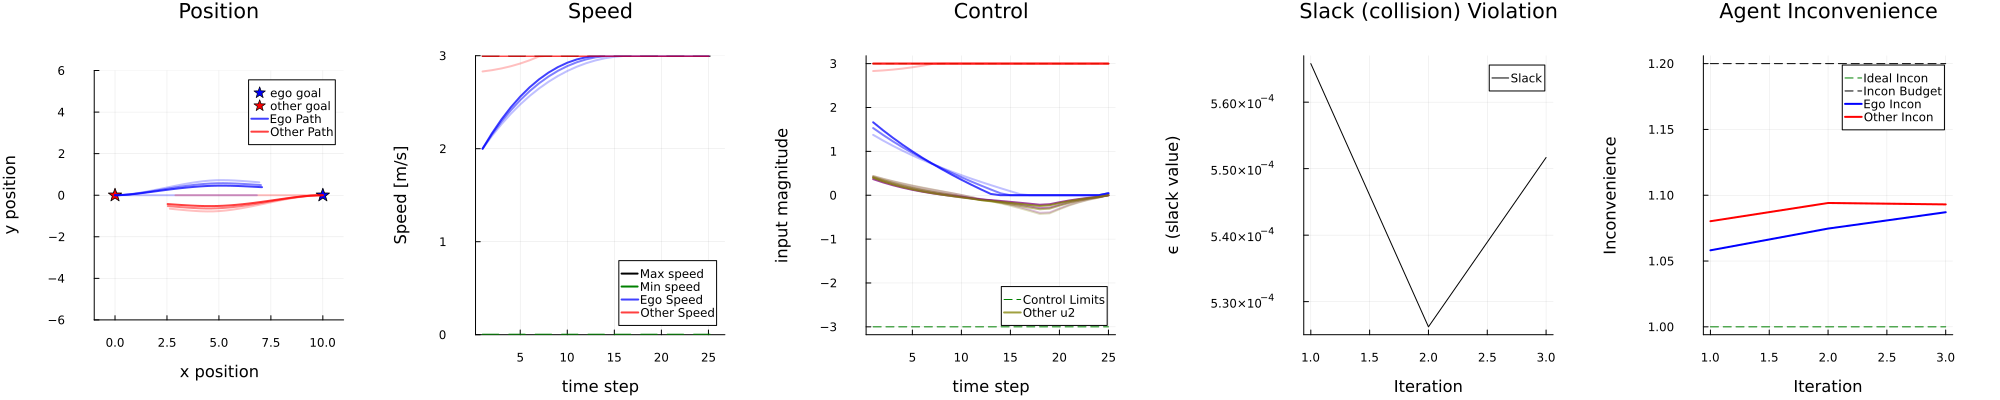

In [563]:
plot_example = plot_solve_solution(saved_data_test, scatter=false, show_speed=true, show_control=true)

In [482]:
savefig(plot_example, "../figs/plot_example.png")

"/home/trajopt/repos/ProactiveHRI.jl/figs/plot_example.png"

In [386]:
ip.ego_planner.ideal.hps.dynamics

DynamicallyExtendedUnicycle{Float64}
  dt: Float64 0.1
  state_dim: Int64 4
  ctrl_dim: Int64 2
  velocity_min: Float64 0.0
  velocity_max: Float64 3.0
  control_min: Array{Float64}((2,)) [-1.0, -3.0]
  control_max: Array{Float64}((2,)) [1.0, 3.0]


In [428]:
vector_of_vectors_to_matrix(ip.ego_planner.incon.opt_params.previous_controls)[:, 1]

25-element Vector{Float64}:
  0.36691290849755104
  0.29281820183403734
  0.22811504102923233
  0.17193011778395717
  0.12326362875692327
  0.08107388754455018
  0.04434078367972758
  0.01210992008137392
 -0.016326163333042834
 -0.04342737502127061
  ⋮
 -0.1942621056226525
 -0.21679873066655317
 -0.20502800793162573
 -0.15993364881644162
 -0.11960546698814874
 -0.08684276565265157
 -0.05833313598277781
 -0.033902340867199836
 -0.0007502881199618999